# Le but de cette partie est d'appliquer un filtrage aux données brutes relevées lors de phases expérimentales pour reconstruire un signal débruité

In [1]:
#importation des librairies utiles pour le traitement
import numpy as np
import matplotlib.pyplot as plt
import csv
import numpy as np
from filterpy.kalman import ExtendedKalmanFilter as EKF
from filterpy.common import Q_discrete_white_noise
from scipy.spatial.transform import Rotation as R
from scipy.signal import butter, filtfilt
import math
from scipy.stats import norm

In [2]:
#on instancie chacune des données expérimentales sous forme d'un dictionnaire temps : vecteur d'état avec la nomenclature suivante
vecteur_etat_exp = {}
'''
position x --> 0
position y --> 1
position z --> 2
quaternion_x -->3
quaternion_y --> 4
quaternion_z --> 5
quaternion_w --> 6
vitesse x --> 7
vitesse y --> 8
vitesse z --> 9
acceleration_x --> 10
acceleration_y --> 11
acceleration_z --> 12
biais_gyro_x --> 13
biais_gyro_y --> 14
biais_gyro_z --> 15
biais_gyro_w --> 16
biais_accelero_x --> 17
biais_accelero_y --> 18
biais_accelero_z --> 19
'''

#on instancie également un dictionnaire contenant les données mesurées avec la nomenclature suivante :
y_mesure = {}
'''
acceleration_x
acceleration_y
acceleration_z
quaternion_x =
quaternion_y =
quaternion_z =
quaternion_w =
'''

#enfin on instancie un vecteur contenant des vitesses théoriques pour vérifier les résultats
vitesse_test = {}
'''
theoric_velocity_x
theoric_velocity_y
'''

'\ntheoric_velocity_x\ntheoric_velocity_y\n'

In [3]:
#on importe désormais d'une expérience les données brutes mesurées ainsi que les données de vitesse théorique
with open('data/donnees_accelerometer_V5_15Hz.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row if exists
    for row in reader:
        vitesse_test[float(row[0])]=[float(row[7]),float(row[8])]
        y_mesure[float(row[0])]=[float(row[4]),float(row[5]),float(row[6]),float(row[9]),float(row[10]),float(row[11]),float(row[12])]

In [4]:
#on définit la matrice de rotation à l'instant time :
def R_from_quaternion(q):
    qx = q[0]
    qy = q[1]
    qz = q[2]
    qw = q[3]

    R = np.array([
        [2*qx**2 + 2*qy**2 - 1, 2*qy*qz - 2*qx*qw, 2*qy*qw + 2*qx*qz],
        [2*qy*qz + 2*qx*qw, 2*qx**2 + 2*qz**2 - 1, 2*qz*qw - 2*qx*qy],
        [2*qy*qw - 2*qx*qz, 2*qz*qw - 2*qx*qy, 2*qx**2 + 2*qx - 1]
    ])

    return R

In [5]:
#on définit la fonction f de transition d'état / on intègre aussi dans f directement le bruti lié au processus / ceci n'influence pas l'étape de linéarisation
def f(x_u_k_1):
    p_k_1 = x_u_k_1[:3]
    q = x_u_k_1[3:7]
    p_prime_k_1 = x_u_k_1[7:10]
    p_seconde_mes = x_u_k_1[10:13]
    p_seconde_k_1 = x_u_k_1[13:16]
    bg_k_1 = x_u_k_1[16:20]
    ba_k_1 = x_u_k_1[20:23]
    q_mes = x_u_k_1[23:27]
    Delta_t = x_u_k_1[27]
    w_gyro = x_u_k_1[28:32]
    w_accel = x_u_k_1[32:35]

    g = np.array([0, 0, 9.81])

    p_new = p_k_1 + Delta_t * p_prime_k_1
    q_new = q_mes - bg_k_1
    R_k_1 = R_from_quaternion(q)
    p_prime_new = p_prime_k_1 + Delta_t * p_seconde_k_1
    p_double_prime_new = (R_k_1@((p_seconde_mes - ba_k_1).T)-g.T).T
    bg_new = bg_k_1 + w_gyro
    ba_new = ba_k_1 + w_accel

    x_new = np.hstack((p_new, q_new, p_prime_new, p_double_prime_new, bg_new, ba_new))

    return x_new

In [6]:
# On définit g / on intègre aussi directement dans g le bruit lié au processus / ceci n'influence pas la linéarisation
G = np.zeros((7,20))
G[0,3]=1
G[1,4]=1
G[2,5]=1
G[3,6]=1
G[4,10]=1
G[5,11]=1
G[6,12]=1
# Fonction g(x_k) qui applique la matrice de transformation à x_k
def g(x_k):
    return G @ x_k

In [7]:
#on définit la fonction de calcul de jacobien (méthode des différences finies)
def jacobian(g, x, epsilon=1e-6):
    n = len(x)
    m = len(g(x))
    J = np.zeros((m, n))
    for i in range(n):
        x_plus = np.array(x, dtype=float)
        x_plus[i] += epsilon
        J[:, i] = (g(x_plus) - g(x)) / epsilon
    return J

#on définit spécifiquement la jacobienne de F (méthode des différences finies)
def jacobianF(x,epsilon=1e-6):
    n = 20
    J = np.zeros((n,n))
    #on ne dérive que par rapport aux variables de l'état X
    count =0
    for i in [0,1,2,3,4,5,6,7,8,9,13,14,15,16,17,18,19,20,21,22]:
        x_plus = np.array(x,dtype=float)
        x_plus[i]+=epsilon
        J[:,count]=(f(x_plus)-f(x))/epsilon
        count+=1
    return J


In [8]:
#on initialise toutes les valeurs utiles:
time = sorted(list(y_mesure.keys()))
vecteur_etat_exp[0.07504796981811523]=np.zeros(20) # Vecteur d'état initial
P_k = np.eye(20)*0.1 # Matrice de covariance initiale
Q_k = np.eye(20)  # Bruit de processus
#le robot est immobile sur les 2 premières secondes ce qui permet d'initialiser le filtre
ax=[]
ay=[]
az=[]
qx=[]
qy=[]
qz=[]
qw=[]
for temps,value in y_mesure.items():

    if float(temps) < 2:
        ax.append(value[0])
        ay.append(value[1])
        az.append(value[2])
        qx.append(value[3])
        qy.append(value[4])
        qz.append(value[5])
        qw.append(value[6])
#on cherche la variance gaussienne qui correspond à nos données
mean_1,sigma_1=norm.fit(ax)
mean_2,sigma_2=norm.fit(ay)
mean_3,sigma_3=norm.fit(az)
mean_4,sigma_4=norm.fit(qx)
mean_5,sigma_5=norm.fit(qy)
mean_6,sigma_6=norm.fit(qz)
mean_7,sigma_7=norm.fit(qw)

R_k = np.diag([sigma_1,sigma_2,sigma_3,sigma_4,sigma_5,sigma_6,sigma_7]) # Bruit de mesure
#on centre les données
for temps,value in y_mesure.items():
    value[0]=value[0]-mean_1
    value[1]=value[1]-mean_2
    value[2]=value[2]-mean_3
    value[3]=value[3]-mean_4
    value[4]=value[4]-mean_5
    value[5]=value[5]-mean_6
    value[6]=value[6]-mean_7

print([sigma_1,sigma_2,sigma_3,sigma_4,sigma_5,sigma_6,sigma_7])

[0.0018574656909785153, 0.0007899863734917432, 0.002815868346258441, 9.184047426577203e-07, 4.449800733609465e-05, 8.855133728300614e-05, 1.4073930791050955e-05]


In [9]:
#on doit définir quel est le bruit du gyroscope et quel est le bruit de l'accéléromètre

In [10]:
#on entre dans la phase de prédiction
for index,step in enumerate(time[:-1]):

    #valeur mesurée à l'instant step
    u = y_mesure[step]
    w_gyro = np.random.normal(0,1/2,4)
    w_accel = np.random.normal(0,1/2,3)
    if index ==0:
        x = np.hstack((vecteur_etat_exp[step][0:3],vecteur_etat_exp[step][3:7],vecteur_etat_exp[step][7:10],u[0:3],vecteur_etat_exp[step][10:14],vecteur_etat_exp[step][14:17],vecteur_etat_exp[step][17:],u[3:],[step],w_gyro,w_accel))
        #print('x vaut {}'.format(x))
        x_k_minus = f(x)
        #on définit notre jacobienne au point x_k_minus
        x = np.hstack((x_k_minus[0:3],x_k_minus[3:7],x_k_minus[7:10],u[0:3],x_k_minus[10:14],x_k_minus[14:17],x_k_minus[17:],u[3:],[step],w_gyro,w_accel))
        F_k = jacobianF(x)
        #print('F_k vaut {}'.format(F_k))
    else:
        x = np.hstack((vecteur_etat_exp[step][0:3],vecteur_etat_exp[step][3:7],vecteur_etat_exp[step][7:10],u[0:3],vecteur_etat_exp[step][10:14],vecteur_etat_exp[step][14:17],vecteur_etat_exp[step][17:],u[3:],[time[index+1]-step],w_gyro,w_accel))
        x_k_minus = f(x)
        #on définit notre jacobienne au point x_k_minus
        x = np.hstack((x_k_minus[0:3],x_k_minus[3:7],x_k_minus[7:10],u[0:3],x_k_minus[10:14],x_k_minus[14:17],x_k_minus[17:],u[3:],[time[index+1]-step],w_gyro,w_accel))
        F_k = jacobianF(x)
    #on passe à la phase de propagation
    P_k_minus = F_k @ P_k @ F_k.T + Q_k
    H_k = jacobian(g,x_k_minus)
    K_k = P_k_minus @ H_k.T @ np.linalg.inv(H_k @ P_k_minus @ H_k.T + R_k)
    x_k = x_k_minus + K_k @ (u-g(x_k_minus))
    P_k = (np.eye(len(x_k)) - K_k @ H_k) @ P_k_minus
    vecteur_etat_exp[time[index+1]]=x_k

In [11]:
vecteur_etat_exp

{0.07504796981811523: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 0.20199179649353027: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.29141297e-04,
        -1.54306044e-04, -2.92415134e-03, -7.20370317e-08,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.70500971e-05,  1.09312255e-07,
        -1.31440486e-04,  8.71789834e-01,  7.17821736e-01, -2.12757468e-01,
         2.33983105e-01,  2.15300187e-01,  6.64081911e-03,  1.33848799e+00]),
 0.36559104919433594: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -4.06876096e-03,
        -4.18436658e-04, -2.61832040e-03,  1.23218479e-07,  3.17200322e-06,
         3.61054034e-06, -2.11553206e-05,  4.52305582e-05,  9.12069372e-05,
        -5.22752630e-05,  9.96310086e-01, -5.47882480e-01, -5.03935466e-01,
        -1.49292110e+00,  6.66278842e-01,  2.66840319e+00,  3.05620188e+00]),
 0.4818270206451416: array([ 3.56669936e-07,  3.98817912e-07, -2.45404627e-

In [15]:
vitesse_x = [300*valeurs[6] for time,valeurs in vecteur_etat_exp.items()]
vitesse_y = [300*valeurs[7] for time,valeurs in vecteur_etat_exp.items()]
vitesse_z = [100*valeurs[8] for time,valeurs in vecteur_etat_exp.items()]
vitesse_y_encodeur=[valeurs[1] for time,valeurs in vitesse_test.items()]
time = list(vecteur_etat_exp.keys())
position_x= [valeurs[0] for valeurs in vecteur_etat_exp.values()]
position_y= [valeurs[1] for valeurs in vecteur_etat_exp.values()]

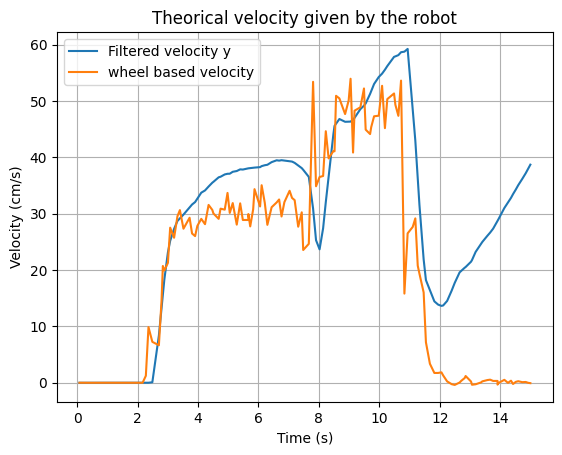

In [16]:
# représentation graphique des valeurs calculées et des valeurs théoriques
plt.plot(time, vitesse_y, label='Filtered velocity y')
plt.plot(time, vitesse_y_encodeur, label='wheel based velocity')

plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')
plt.title('Theorical velocity given by the robot')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
# représentation graphique de la position calculée
plt.plot(position_x, position_y, label='Filtered position')

plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.title('Filtered position given by the IMU')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
#représentation de la vitesse de y et z
plt.plot(time, vitesse_x, label='Filtered velocity x')
plt.plot(time, vitesse_z, label='Filtered velocity z')

plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')
plt.title('Filtered velocity given by the IMU')
plt.legend()
plt.grid(True)
plt.show()

In [84]:
# calcul de corrélation entre les signaux
def coefficient_pearson(signal1, signal2):
    # Convertir les signaux en tableaux NumPy
    signal1 = np.array(signal1)
    signal2 = np.array(signal2)

    # Calculer les moyennes des signaux
    mean1 = np.mean(signal1)
    mean2 = np.mean(signal2)

    # Calculer les termes numérateur et dénominateur
    num = np.sum((signal1 - mean1) * (signal2 - mean2))
    den = np.sqrt(np.sum((signal1 - mean1)**2) * np.sum((signal2 - mean2)**2))

    # Calculer le coefficient de corrélation de Pearson
    if den == 0:
        return 0
    else:
        return num / den


#sur l'expérience totale
score_total = coefficient_pearson(vitesse_y[1:],vitesse_y_encodeur)
#sur les 12 premières secondes uniquement
score_partiel = coefficient_pearson(vitesse_y[1:-40], vitesse_y_encodeur[:-40])

In [88]:
print('score de similarité entre le signal test et celui recontruit est {}.'.format(score_total))
print('score de similarité entre le signal test et celui recontruit sur les 12 premières secondes du test est {}.'.format(score_partiel))

score de similarité entre le signal test et celui recontruit est 0.7756369482089326.
score de similarité entre le signal test et celui recontruit sur les 12 premières secondes du test est 0.9073117223223128.
